# CS231n Winter 2016: Lecture 2
## Topics: Data-driven approach, kNN, Linear Classification 1

video:
https://www.youtube.com/watch?v=8inugqHkfvE

In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/8inugqHkfvE?rel=0&amp;controls=1&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

## Preconditions
Used Data sets: **CIFAR-10**
- 10 labels
- 50,000 training images (32x32)
- 10,000 test images
- keras has it (`from keras.datasets import cifar10`)
- https://github.com/tensorflow/models/tree/master/tutorials/image/cifar10 or https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/cifar10.py - fetch for tensorflow

In [2]:
%matplotlib inline

from keras.datasets import cifar10
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

cifar10_categories = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# util functions
def grid_of_images(cols, rows, image_callback, grid_width=8):
    """
    Show images in a grid
    """
    plt.figure(figsize=(grid_width, grid_width / cols * rows))
    gs = gridspec.GridSpec(rows, cols)

    for row_idx in range(rows):
        for col_idx in range(cols):
            plt.subplot(gs[row_idx, col_idx])
            plt.axis('off')
            image, title = image_callback(row_idx, col_idx)
            plt.imshow(image, interpolation='none')
            if title is not None:
                plt.title(title)
    plt.tight_layout()

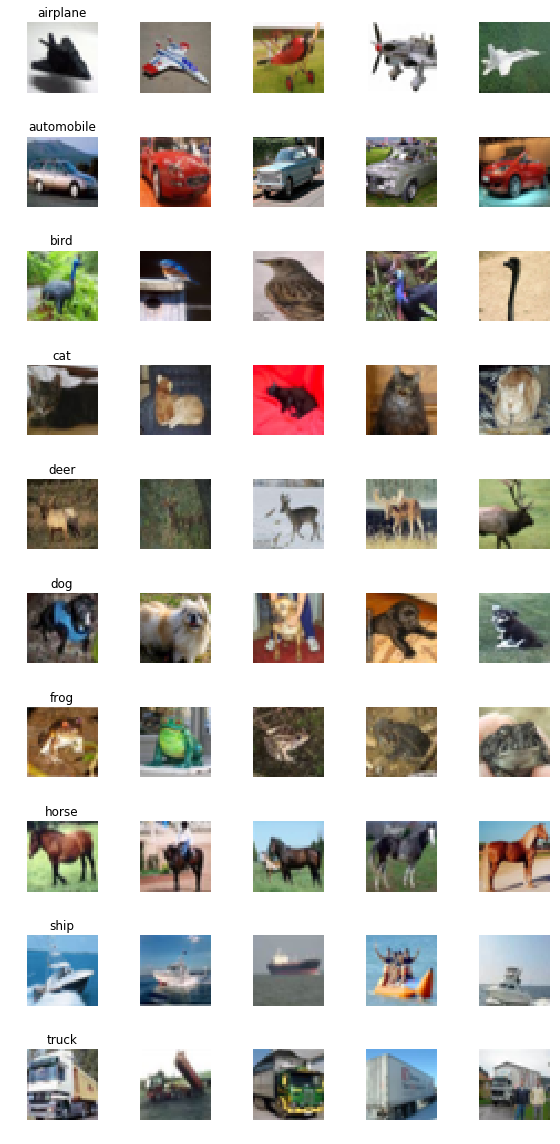

In [4]:
def get_images_by_category(category_idx):
    return x_train[np.where(y_train == category_idx)[0]]

def get_image(category_idx, image_idx):
    return get_images_by_category(category_idx)[image_idx], cifar10_categories[category_idx] if image_idx == 0 else None

grid_of_images(5, len(cifar10_categories), get_image, grid_width=8)

## Common Classifier

In [5]:
def train(train_images, train_labels):
    # build model
    return model

def predict(model, test_images):
    # predict
    return test_labels

## Nearest Neighbour Classifier
property
- accuracy on training set is 100%
- speed: 
$$
distance_speed = width*height*num_trained_samples 
$$
$$
atgmin_speed = num_trained_samples
$$
$$
speed = distance_speed
$$
- libs FLANN - fast library for aproximate NN

In [6]:
class NearestNeighbour:
    def train(self, X, y):
        """
        train model with example and labels
        """
        # remember all images
        assert len(X.shape) == 4
        assert len(y.shape) == 2
        self.X_trained = X
        self.y_trained = y
        return self

    def predict(self, X):
        """
        Predict labels for items
        """
        
        if len(X.shape) == 3:
            X = np.expand_dims(X, axis=0)
            
        assert len(X.shape) == 4
        
        for instance in X:
            # - manhattan distance (L1 distance)
            distance = np.sum(np.abs(self.X_trained - instance), axis = (1,2,3))
            min_index = np.argmin(distance)
            yield self.y_trained[min_index][0]

In [7]:
nn = NearestNeighbour().train(x_train, y_train)
%time list(nn.predict(x_test[:10]))

CPU times: user 3.16 s, sys: 890 ms, total: 4.05 s
Wall time: 4.05 s


[8, 8, 1, 0, 4, 2, 2, 5, 0, 8]

### kNN

big differences to Nearest Neighbour are
- get k-instances the most likely 
- make majority vote

property:
- for k > 1, accuracy on training set is < 100%
- k - hyper parameter
- in comparison to Nearest Neighbour it smoothes boundaries

practice
- never used on images
- terrible performance on test time
- distance metrics on level of whole images can be very unintuitive

In [8]:
class KNearestNeighbour:
    def __init__(self, k=5):
        self.k = k

    def train(self, X, y):
        """
        train model with example and labels
        """
        # remember all images
        assert len(X.shape) == 4
        assert len(y.shape) == 2
        self.X_trained = X
        self.y_trained = y
        return self

    def predict(self, X):
        """
        Predict labels for items
        
        it will return the most likely class, probability of each class and list of the most likely images
        return:
            category_id, 
            frequency of category,
            distance of image,
            closest images,
        """
        
        if len(X.shape) == 3:
            X = np.expand_dims(X, axis=0)
            
        assert len(X.shape) == 4
        
        for instance in X:
            # - manhattan distance (L1 distance)
            distance = np.sum(np.abs(self.X_trained - instance), axis = (1,2,3))
            min_indexes = distance.argsort()[:self.k]
            counts = np.bincount(self.y_trained[min_indexes].ravel())
            yield np.argmax(counts), counts / counts.sum(), distance[min_indexes], min_indexes

In [9]:
# make a modal and do prediction
nn = KNearestNeighbour().train(x_train, y_train)
%time predictions = list(nn.predict(x_test[:10]))

CPU times: user 2.67 s, sys: 890 ms, total: 3.56 s
Wall time: 3.57 s


CPU times: user 2.29 s, sys: 40 ms, total: 2.33 s
Wall time: 2.32 s


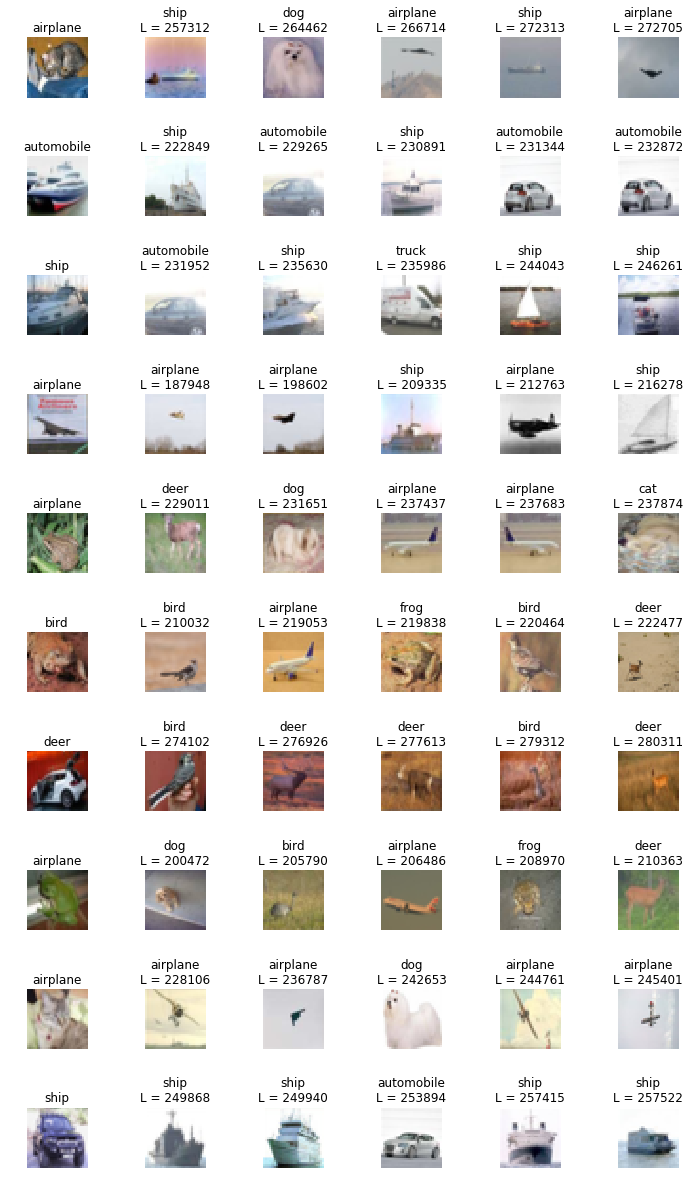

In [10]:
def build_get_image(test_images, train_categories):
    def get_image(test_idx, sample_idx):
        prediction = predictions[test_idx]
        if sample_idx == 0:
            # show test image
            category_idx = prediction[0]
            return test_images[test_idx], cifar10_categories[category_idx]
        else:
            # show the closest images
            distance = prediction[2][sample_idx - 1]
            
            image_idx = prediction[3][sample_idx - 1]
            category_idx = train_categories[image_idx][0]
            category_title = cifar10_categories[category_idx]
            
            return x_train[image_idx], f'{category_title}\nL = {distance}'
    return get_image

%time grid_of_images(6, 10, build_get_image(x_test, y_train), grid_width=10)

## Tuning hyper parameters

use cross validation on folds and forget about test set until we will ready to make finaly estimation

In [11]:
# TODO: try cross validatino on cifar-10
# - show graphics _accuracy by k_ and animate it

## Linear Classifier

$$
f(x, W) = Wx + b
$$
where $x$ - image, $W$ - weights, $b$ - bieses, result is class scores

- Lost function
- Optimization
- ConvNets

In [12]:
# TODO: visualize W
# 1) take each row of W
# 2) reshape it back to the image (wxh)